In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 

%matplotlib inline

In [2]:
loo_data = {}
sector_data = {}

In [92]:
loo_values = np.empty(shape=(240,6))
loo_errors = np.empty(shape=(240,6))
sector_values = np.empty(shape=(240,6))
sector_errors = np.empty(shape=(240,6))
loo_sample_size = np.empty(shape=(240,6))
sector_sample_size = np.empty(shape=(240,6))

for s in range(1,7):
    loo_data[s] = pd.read_csv(f'../database/phi/loo/sector_{s}.csv')
    sector_data[s] = pd.read_csv(f'../database/phi/sector_{s}.csv')
    
    loo_values[:,s-1] = loo_data[s]['value'].values
    loo_errors[:,s-1] = loo_data[s]['stat'].values
    sector_values[:,s-1] = sector_data[s]['value'].values
    sector_errors[:,s-1] = sector_data[s]['stat'].values
    
    loo_sample_size[:,s-1] = np.abs(loo_data[s]['counts_pos'].values - loo_data[s]['counts_neg'])
    sector_sample_size[:,s-1] = np.abs(sector_data[s]['counts_pos'].values - sector_data[s]['counts_neg']) 
    

### Define Normal Distribution For Each Point
We assume that the five sectors are "correct" together, and evaluate the probability of the sixth coming from the distribution they define.

In [13]:
from scipy.stats import norm

In [6]:
def normal_distribution(x, mu, sigma):
    return np.exp(-0.5 * (x-mu)**2 / sigma**2 ) / sigma / np.sqrt(2 * np.pi)

In [7]:
prob = np.zeros(shape=(240,6))

In [71]:
for s in range(6):
    for i in range(240):
        normal_dist = norm(loc=loo_values[i,s], 
                           scale=np.sqrt(loo_errors[i,s]**2 + sector_errors[i,s]**2))
        
        if sector_values[i,s] < loo_values[i,s]:
            prob[i,s] = 2 * normal_dist.cdf(sector_values[i,s])
        else:
            prob[i,s] = 2 * (1. - normal_dist.cdf(sector_values[i,s]))

In [72]:
prob[0]

array([0.18667722, 0.41490247, 0.88255424, 0.28737466, 0.70495231,
       0.40442383])

In [73]:
loo_values[0]

array([ 5.6099560e-05, -2.9484420e-04,  6.5452090e-04, -8.1246440e-03,
       -1.1048606e-04,  2.1144582e-03])

In [74]:
sector_values[0]

array([-0.02081345, -0.01318088,  0.00295201, -0.02486759, -0.00607623,
        0.01529499])

In [75]:
prob.shape

(240, 6)

In [76]:
prob.mean(axis=0)

array([0.45943183, 0.42185996, 0.42400639, 0.47465371, 0.39384433,
       0.46706368])

Text(0.5, 0, 'Probability threshold')

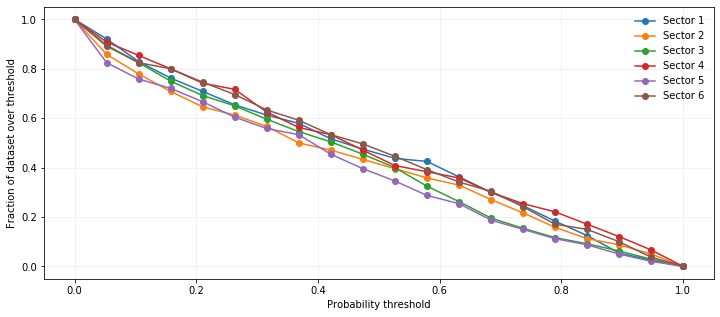

In [79]:
prob_thresholds = np.linspace(0, 1, 20)

plt.figure(figsize=(12,5))
for s in range(6):
    npts = [len(np.where(prob[:,s] > t)[0]) for t in prob_thresholds]
    npts = np.array(npts)
    plt.plot(prob_thresholds, npts / 240., marker='o', label=f'Sector {s+1}')

plt.grid(alpha=0.2)
plt.legend(frameon=False)
plt.ylabel('Fraction of dataset over threshold')
plt.xlabel('Probability threshold')

In [83]:
from scipy.stats import ttest_ind

In [93]:
ttest = np.zeros((240,6))

for s in range(6):
    for i in range(240):
        rv1 = norm.rvs(loc=loo_values[i,s], scale=loo_errors[i,s], size=int(loo_sample_size[i,s]))
        rv2 = norm.rvs(loc=sector_values[i,s], scale=sector_errors[i,s], size=int(sector_sample_size[i,s]))
        pval = ttest_ind(rv1, rv2, equal_var=False).pvalue
        ttest[i,s] = pval

In [95]:
ttest[5]

array([6.77183253e-07, 3.96445022e-07, 5.72170834e-03, 1.84584854e-06,
       4.63873727e-02, 1.19494172e-07])

Text(0.5, 0, 'Probability threshold')

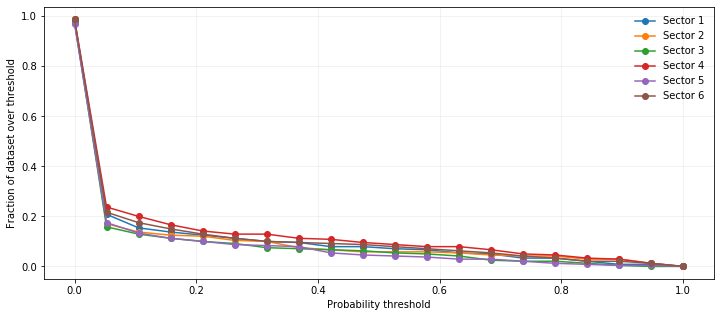

In [96]:
prob_thresholds = np.linspace(0, 1, 20)

plt.figure(figsize=(12,5))
for s in range(6):
    npts = [len(np.where(ttest[:,s] > t)[0]) for t in prob_thresholds]
    npts = np.array(npts)
    plt.plot(prob_thresholds, npts / 240., marker='o', label=f'Sector {s+1}')

plt.grid(alpha=0.2)
plt.legend(frameon=False)
plt.ylabel('Fraction of dataset over threshold')
plt.xlabel('Probability threshold')

In [97]:
prob.mean(axis=0)

array([0.45943183, 0.42185996, 0.42400639, 0.47465371, 0.39384433,
       0.46706368])

In [99]:
resample_values = np.empty(shape=(240,6))
resample_errors = np.empty(shape=(240,6))
resample_data = {} 

for s in range(1,7):
    resample_data[s] = pd.read_csv(f'../database/phi/bootstrap_est_sector_{s}.csv')
    resample_values[:,s-1] = resample_data[s]['value'].values
    resample_errors[:,s-1] = resample_data[s]['stat'].values

In [100]:
prob_resample = np.empty(shape=(240,6))

for s in range(6):
    for i in range(240):
        normal_dist = norm(loc=loo_values[i,s], 
                           scale=np.sqrt(loo_errors[i,s]**2 + resample_errors[i,s]**2))
        
        if resample_values[i,s] < loo_values[i,s]:
            prob_resample[i,s] = 2 * normal_dist.cdf(resample_values[i,s])
        else:
            prob_resample[i,s] = 2 * (1. - normal_dist.cdf(resample_values[i,s]))

Text(0.5, 0, 'Probability threshold')

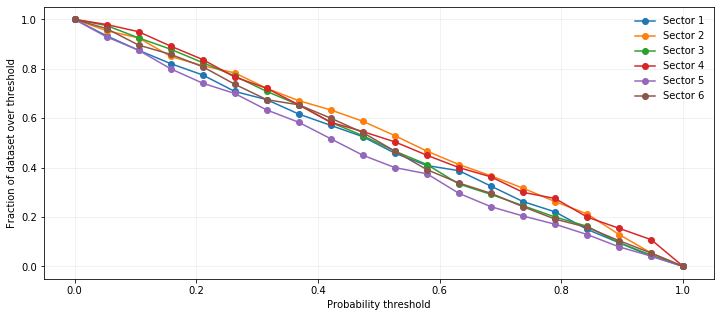

In [101]:
prob_thresholds = np.linspace(0, 1, 20)

plt.figure(figsize=(12,5))
for s in range(6):
    npts = [len(np.where(prob_resample[:,s] > t)[0]) for t in prob_thresholds]
    npts = np.array(npts)
    plt.plot(prob_thresholds, npts / 240., marker='o', label=f'Sector {s+1}')

plt.grid(alpha=0.2)
plt.legend(frameon=False)
plt.ylabel('Fraction of dataset over threshold')
plt.xlabel('Probability threshold')

In [102]:
for s in range(6):
    for i in range(240):
        normal_dist = norm(loc=loo_values[i,s], 
                           scale=loo_errors[i,s])
        
        if sector_values[i,s] < loo_values[i,s]:
            prob[i,s] = 2 * normal_dist.cdf(sector_values[i,s])
        else:
            prob[i,s] = 2 * (1. - normal_dist.cdf(sector_values[i,s]))

Text(0.5, 0, 'Probability threshold')

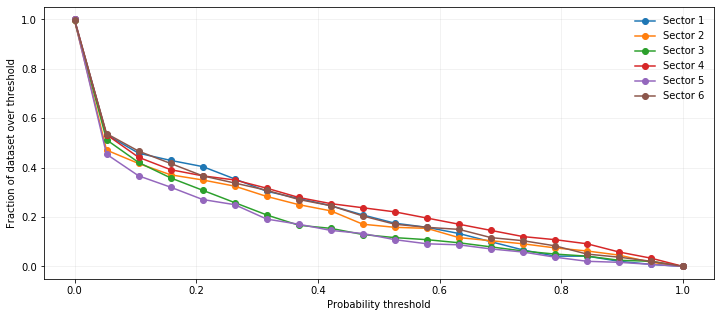

In [103]:
prob_thresholds = np.linspace(0, 1, 20)

plt.figure(figsize=(12,5))
for s in range(6):
    npts = [len(np.where(prob[:,s] > t)[0]) for t in prob_thresholds]
    npts = np.array(npts)
    plt.plot(prob_thresholds, npts / 240., marker='o', label=f'Sector {s+1}')

plt.grid(alpha=0.2)
plt.legend(frameon=False)
plt.ylabel('Fraction of dataset over threshold')
plt.xlabel('Probability threshold')

In [111]:
increasing_errors_indices = np.argsort(loo_errors.sum(axis = 1))

Text(0.5, 1.0, 'Top 200 points')

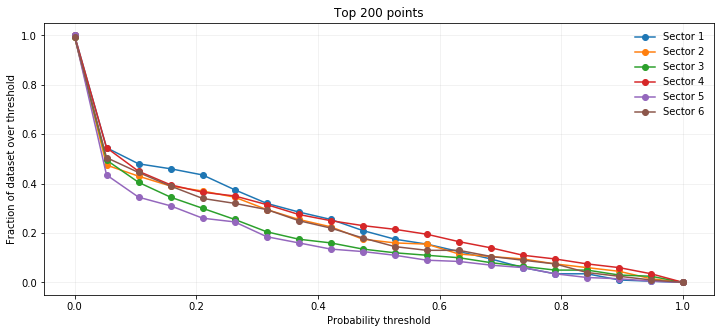

In [117]:
prob_thresholds = np.linspace(0, 1, 20)
top_k = 200

plt.figure(figsize=(12,5))
for s in range(6):
    npts = [len(np.where(prob[increasing_errors_indices[:top_k],s] > t)[0]) for t in prob_thresholds]
    npts = np.array(npts)
    plt.plot(prob_thresholds, npts / float(top_k), marker='o', label=f'Sector {s+1}')

plt.grid(alpha=0.2)
plt.legend(frameon=False)
plt.ylabel('Fraction of dataset over threshold')
plt.xlabel('Probability threshold')
plt.title(f'Top {top_k} points')